<a href="https://colab.research.google.com/github/rutuja-patil24/CMPE-258-Deep_Learning/blob/main/Assignment_07/Part_2_03_custom_optimizer_trainingloop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# Load and preprocess MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 784).astype("float32") / 255.0
x_test = x_test.reshape(-1, 784).astype("float32") / 255.0

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1000).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

In [10]:
# Define the model
class SimpleNN(keras.Model):
    def __init__(self):
        super().__init__()
        self.d1 = layers.Dense(128, activation="relu")
        self.d2 = layers.Dense(10)

    def call(self, x):
        return self.d2(self.d1(x))

model = SimpleNN()

In [11]:
# Dummy forward pass to initialize model variables
_ = model(x_train[:1])

# Initialize momentum buffers using id(var) as key
velocities = {id(var): tf.Variable(tf.zeros_like(var)) for var in model.trainable_variables}

# Hyperparameters
learning_rate = 0.01
momentum = 0.9
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Logging
train_loss_list = []
test_loss_list = []

Epoch 1: Train Loss = 0.0520, Test Loss = 0.0819, Test Accuracy = 0.9752
Epoch 2: Train Loss = 0.0477, Test Loss = 0.0776, Test Accuracy = 0.9769
Epoch 3: Train Loss = 0.0436, Test Loss = 0.0745, Test Accuracy = 0.9772
Epoch 4: Train Loss = 0.0403, Test Loss = 0.0723, Test Accuracy = 0.9784
Epoch 5: Train Loss = 0.0369, Test Loss = 0.0721, Test Accuracy = 0.9791


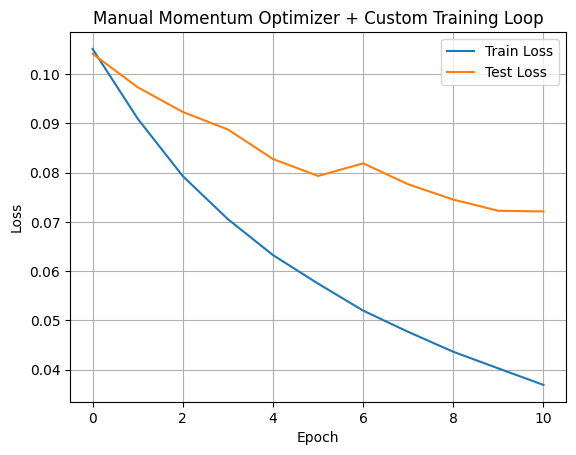

In [16]:
# Training loop
for epoch in range(5):
    total_loss = 0.0
    for x_batch, y_batch in train_ds:
        with tf.GradientTape() as tape:
            logits = model(x_batch, training=True)
            loss = loss_fn(y_batch, logits)
        grads = tape.gradient(loss, model.trainable_variables)

        for var, grad in zip(model.trainable_variables, grads):
            if grad is not None:
                v = velocities[id(var)]
                v.assign(momentum * v - learning_rate * grad)
                var.assign_add(v)

        total_loss += loss.numpy()

    # Evaluation
    test_logits = model(x_test, training=False)
    test_loss = loss_fn(y_test, test_logits).numpy()
    acc = tf.keras.metrics.sparse_categorical_accuracy(y_test, test_logits)

    avg_train_loss = total_loss / len(train_ds)
    train_loss_list.append(avg_train_loss)
    test_loss_list.append(test_loss)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Test Loss = {test_loss:.4f}, Test Accuracy = {np.mean(acc):.4f}")

    # Plot Loss
plt.plot(train_loss_list, label="Train Loss")
plt.plot(test_loss_list, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Manual Momentum Optimizer + Custom Training Loop")
plt.legend()
plt.grid(True)
plt.show()
